---
## Technical Report Notebook 4
---
### Modelling Extension - Hailstorm Severity + Earthquake Classification Investigations

This notebook extends the tweet investigations into two different classificiation exercises, to answer the following questions:

    1. Can tweets predict a hail event of differing magnitude?
    2. Can tweets predict other types of natural catastrophes?

### 4.i. Hail Severity Test

Now we know that tweets can effectively predict hail using a classification algorithm, a secondary investigation event severity will be conducted. The purpose of this is to investigate whether the language used in the more severe Brisbane (2014) event is different to Sydney (2015).

To do this I will adjust the classification exercise using the event ID's as classes:

- Brisbane Hail (Cat_ID - 144):   **1**
- Sydney Hail (Cat_ID - 154):   **0**

In [2]:
# Import modelling libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
# Create hail and earthquake classes

hail_tweet_text_hail = hail_tweet_text.ix[hail_tweet_text['hail'] > 0]                            

hail_tweet_text_hail['event_class'] = 0

hail_tweet_text_hail.ix[hail_tweet_text_hail['Cat_ID'] == 144, 'event_class'] = 1

print(hail_tweet_text_hail.shape)

y_hail = hail_tweet_text_hail['event_class']

(4786, 1026)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


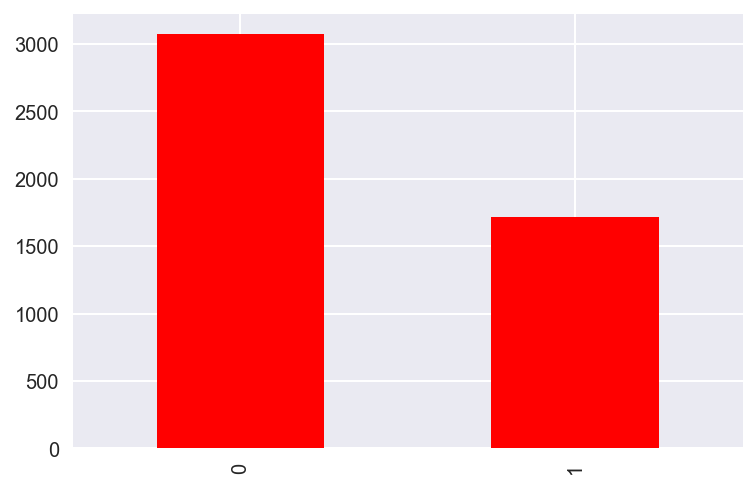

In [10]:
hail_tweet_text_hail['event_class'].value_counts().plot(kind='bar',color='red')

In [96]:
hail_tweets = hail_tweet_text_hail.ix[:,26:]
print (hail_tweets.shape)

hail_tweets.drop(hail_tweets[['hail','hailstorm','event_class','australia','bnestorm','queensland','sydney','sydneystorm','brisbane','brisbanestorm']], axis=1, inplace=True)
print (hail_tweets.shape)

ss = StandardScaler()
Xs_hail_total = ss.fit_transform(hail_tweets)

(4786, 1002)
(4786, 992)


### _Random Forest Classification_

In [97]:
tf_transformer = TfidfTransformer(use_idf=False).fit(Xs_hail_total)
X_hail = tf_transformer.transform(Xs_hail_total)

X_train_hail, X_test_hail, y_train_hail, y_test_hail = train_test_split(X_hail, y_hail, test_size=0.8)

rfc_hail = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_hail.fit(X_train_hail, y_train_hail)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [100]:
# Extract the top features from the decision tree classifier.

top_features_rfc_hail = pd.DataFrame({
        'feature':hail_tweets.columns,
        'importance':rfc_hail.feature_importances_})

top_features_rfc_hail.sort_values('importance', ascending=False, inplace=True)
top_features_rfc_hail.head(20)

,feature,importance
139,chaos,0.029449
798,storm,0.026837
991,sentiment,0.022198
819,super,0.019924
45,ball,0.018387
504,massive,0.017496
973,worst,0.015561
319,golf,0.013815
117,car,0.009927
762,smashed,0.009533


In [105]:
rfc_hail_scores = cross_val_score(rfc_hail, X_test_hail, y_test_hail, cv=5)

print (rfc_hail_scores)
print (sum(rfc_hail_scores)/len(rfc_hail_scores))

# Create predicted y values

yhat_test_rfc_hail = rfc_hail.predict(X_test_hail)
yhat_test_rfc_hail_pp = rfc_hail.predict_proba(X_test_hail)

# convert the predicted and actual values to a confusion array

confusion_array_rfc = confusion_matrix(y_test_hail, yhat_test_rfc_hail, labels=[1,0])

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['severe','moderate'],
                         columns=['pred_severe','pred_moderate'])

print ("confusion matrix")
print (confusion_rfc)
print ("--------")
print ("accuracy:", accuracy_score(y_test_hail, yhat_test_rfc_hail)) # accuracy = (tp + tn) / total_population)
print ("--------")
print (classification_report(y_test_hail, yhat_test_rfc_hail))

[ 0.82245431  0.79634465  0.79634465  0.7767624   0.80130719]
0.798642638953
confusion matrix
          pred_severe  pred_moderate
severe            698            682
moderate          200           2249
--------
accuracy: 0.769652650823
--------
             precision    recall  f1-score   support

          0       0.77      0.92      0.84      2449
          1       0.78      0.51      0.61      1380

avg / total       0.77      0.77      0.76      3829



### 4.ii. Earthquake Classification Investigation

In the tweet EDA we identified another type of natural catastrophe - an earthquake event in Nepal. The economic loss of this event is estimated to be in excess of USD 6 billion.

The identification of another type of catastrophe in this study can let me investigate whether our optimal hail algorithm can also effectively identify tweets of a second type of catastrophe.

Firstly I will create a new class target using 'hail' and 'earthquake' text from our data previously prepared for modelling...

In [7]:
# Read in data:

hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

Setting up the classification exercise with earthquake and hail classes (0, 1, 2)

In [8]:
# Create hail and earthquake classes

hail_tweet_text['catastrophe_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'catastrophe_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'catastrophe_class'] = 1

hail_tweet_text.ix[hail_tweet_text['earthquake'] >= 1, 'catastrophe_class'] = 2
hail_tweet_text.ix[hail_tweet_text['quake'] >= 1, 'catastrophe_class'] = 2

y_total = hail_tweet_text['catastrophe_class']

In [65]:
htt_total = hail_tweet_text.ix[:,26:]
print (htt_total.shape)

htt_total.drop(htt_total[['hail','hailstorm','earthquake','quake','catastrophe_class']], axis=1, inplace=True)
print (htt_total.shape)

ss = StandardScaler()
Xs_htt_total = ss.fit_transform(htt_total)

(127989, 1002)
(127989, 997)


### Random Forest Classification

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

In [67]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_total_tf, y_total, test_size=0.5)

rfc_total = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [68]:
rfc_scores = cross_val_score(rfc_total, X_test, y_test, cv=5)

print (mnb_scores)
print (sum(mnb_scores)/len(mnb_scores))

[ 0.95320678  0.95234003  0.95507462  0.95186748  0.94991405]
0.952480590171


In [70]:
# Create predicted y values

yhat_test_rfc = rfc_total.predict(X_test)
yhat_test_rfc_pp = rfc_total.predict_proba(X_test)

# convert the predicted and actual values to a confusion array

confusion_array_rfc = confusion_matrix(y_test, yhat_test_rfc, labels=[2,1,0])

confusion_mnb = pd.DataFrame(confusion_array_rfc, index=['eq', 'hail','no cat'],
                         columns=['pred_eq','pred_hail', 'pred_no'])
confusion_mnb

,pred_eq,pred_hail,pred_no
eq,2248,2,526
hail,0,1108,1313
no cat,263,232,58303


In [71]:
y_test.value_counts()

0    58798
2     2776
1     2421
Name: catastrophe_class, dtype: int64

In [72]:
np.unique(yhat_test_mnb)

array([0, 1, 2])